# HW-6 - Trees
In this homework, we will use the California Housing Prices from Kaggle.

https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

The goal of this homework is to create a regression model for predicting housing prices (column `median_house_value`).

## 1. Import the libraries

In [24]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## 2. Preparing the dataset

For this homework, we only want to use a subset of data. This is the same subset we used in homework #2. But in contrast to homework #2, we are going to use all columns of the dataset.

In [2]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv"
dff = pd.read_csv(url)

In [3]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


First, keep only the records where `ocean_proximity` is either `<1H OCEAN` or `INLAND`.

In [4]:
dff["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [5]:
# Create the filter for 'ocean_proximity'
df = dff.copy()
mask = (df["ocean_proximity"] == "<1H OCEAN") + (df["ocean_proximity"] == "INLAND")
# Apply the filter for 'ocean_proximity' in a new dataset df_filter
df = df[mask]
df.info() # Validate structure of the dataset

<class 'pandas.core.frame.DataFrame'>
Index: 15687 entries, 701 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15530 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
 9   ocean_proximity     15687 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


Preparation:
- Fill missing values with zeros.

In [6]:
df.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        157
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
df["total_bedrooms"].fillna(value=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15687 entries, 701 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15687 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
 9   ocean_proximity     15687 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


In [8]:
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [9]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


- Apply the **log transform** to `median_house_value`.

In [10]:
df["median_house_value"] = np.log1p(df["median_house_value"])
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
701,-121.97,37.64,32.0,1283.0,194.0,485.0,171.0,6.0574,12.973866,<1H OCEAN
830,-121.99,37.61,9.0,3666.0,711.0,2341.0,703.0,4.6458,12.287657,<1H OCEAN
859,-121.97,37.57,21.0,4342.0,783.0,2172.0,789.0,4.6146,12.419574,<1H OCEAN
860,-121.96,37.58,15.0,3575.0,597.0,1777.0,559.0,5.7192,12.554971,<1H OCEAN
861,-121.98,37.58,20.0,4126.0,1031.0,2079.0,975.0,3.6832,12.287196,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,11.265758,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,11.252872,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,11.432810,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,11.346883,INLAND


- Do **train/validation/test** split with 60%/20%/20% distribution.
- Use the `train_test_split` function and set the `random_state` parameter to **1**.

In [11]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train["median_house_value"].values
y_val = df_val["median_house_value"].values
y_test = df_test["median_house_value"].values

del df_train["median_house_value"]
del df_val["median_house_value"]
del df_test["median_house_value"]

- Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [12]:
# Initializing training features
features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households',
            'median_income', 'ocean_proximity']
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [13]:
# Instantiate DictVectorizer
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

## Question 1

Let's train a **decision tree regressor** to predict the `median_house_value` variable.

- Train a model with `max_depth=1`.

Which feature is used for splitting the data? \
-<u>**`ocean_proximity`**</u> \
-`total_rooms`\
-`latitude`\
-`population`

In [14]:
# Instantiate the model
dt = DecisionTreeRegressor(max_depth=1)
# Train the model
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [15]:
# Inspect the tree
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



- Which feature is used for splitting the data? = **`ocean_proximity`**

## Question 2

Train a **random forest** model with these parameters:

`n_estimators=10` \
`random_state=1` \
`n_jobs=-1` (optional - to make training faster)

What's the **RMSE** of this model on validation? \
-`0.045`\
-<u>**`0.245`**</u>\
-`0.545`\
-`0.845`

In [16]:
# Instantiate the model
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
# Fit the model
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [17]:
# Calculate the RMSE
y_pred = rf.predict(X_val)
np.sqrt(mean_squared_error(y_val, y_pred))

0.24527740463893766

- What's the RMSE of this model on validation? = **`0.245`**

## Question 3

Now let's experiment with the `n_estimators` parameter.

- Try different values of this parameter from **10 to 200** with **step 10**.
- Set `random_state` to **1**.
- Evaluate the model on the validation dataset.

After which value of `n_estimators` does **RMSE stop improving**? Consider 3 decimal places for retrieving the answer.\
-`10`\
-`25`\
-<u>**`50`**</u>\
-`160`

In [38]:
# Create a loop for training the model with different 'n_estimators'
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

100%|██████████████████████████████████████████| 20/20 [17:19<00:00, 51.98s/it]


In [39]:
df_scores

,n_estimators,rmse
0,10,0.245277
1,20,0.239041
2,30,0.236995
3,40,0.235509
4,50,0.235162
5,60,0.234711
6,70,0.234574
7,80,0.234815
8,90,0.234593
9,100,0.234415


In [41]:
round(df_scores["rmse"], 3)

0     0.245
1     0.239
2     0.237
3     0.236
4     0.235
5     0.235
6     0.235
7     0.235
8     0.235
9     0.234
10    0.234
11    0.234
12    0.234
13    0.234
14    0.234
15    0.234
16    0.233
17    0.234
18    0.234
19    0.234
Name: rmse, dtype: float64

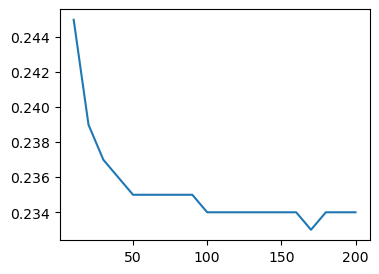

In [40]:
# Plot the RMSE scores
plt.figure(figsize=(4, 3))
plt.plot(df_scores["n_estimators"], df_scores["rmse"].round(3))
plt.show()

- After which value of `n_estimators` does **RMSE stop improving**? Consider 3 decimal places for retrieving the answer. = **`50`**

## Question 4

Let's select the best `max_depth`:

- Try different values of `max_depth`: `[10, 15, 20, 25]`
- For each of these values,
    - try different values of `n_estimators` from **10 till 200** (with **step 10**)
    - calculate the **mean RMSE**
- Fix the random seed: `random_state=1`

What's the best `max_depth`, using the mean RMSE? \
-`10`\
-`15`\
-`20`\
-<u>**`25`**</u>

In [36]:
# Create a loop for training the model with different 'max_depth'
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(n_estimators=0,
                               max_depth=d,
                               random_state=1, n_jobs=-1,
                               warm_start=True)

    for n in range(10, 201, 10):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

100%|███████████████████████████████████████████| 4/4 [06:42<00:00, 100.73s/it]


In [37]:
df_scores

,max_depth,n_estimators,rmse
0,10,10,0.250677
1,10,20,0.247672
2,10,30,0.246434
3,10,40,0.245168
4,10,50,0.245557
...,...,...,...
75,25,160,0.233405
76,25,170,0.233419
77,25,180,0.233576
78,25,190,0.233819


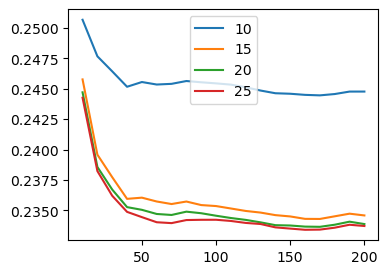

In [19]:
# Plot the 'max_depth' & 
plt.figure(figsize=(4, 3))
for d in [10, 15, 20, 25]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

- What's the best `max_depth`, using the mean RMSE? = **`25`**

## Question 5

We can extract **feature importance** information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate **"gain"** - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the `feature_importances_ field`.

For this homework question, we'll find the most important feature:

- Train the model with these parameters:
    - `n_estimators=10`,
    - `max_depth=20`,
    - `random_state=1`,
    - `n_jobs=-1` (optional)
- Get the feature importance information from this model

What's the **most important feature** (among these 4)? \
-`total_rooms`\
-<u>**`median_income`**</u>\
-`total_bedrooms`\
-`longitude`

In [20]:
# Train the random forest model
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20, 
                           random_state=1,
                           n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
# Inspect the feature importance
rf.feature_importances_

array([0.0151361 , 0.03031726, 0.10200703, 0.08624381, 0.33561113,
       0.29247297, 0.07380644, 0.02713606, 0.01585222, 0.02141699])

In [22]:
# Feature importances as dataframe
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False)

,feature,importance
4,median_income,0.335611
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.102007
3,longitude,0.086244
6,ocean_proximity=INLAND,0.073806
1,housing_median_age,0.030317
7,population,0.027136
9,total_rooms,0.021417
8,total_bedrooms,0.015852
0,households,0.015136


- What's the **most important feature**? = **`median_income`**

## Question 6

Now let's train an **XGBoost model**! For this question, we'll tune the **`eta`** parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change **`eta`** from `0.3` to `0.1`.

Which **`eta`** leads to the **best RMSE** score on the validation dataset? \
-`0.3`\
-`0.1`\
-<u>**Both give equal value**</u>

In [25]:
# Create the matrix
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [26]:
# Initialize
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [27]:
# Define the function
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [31]:
%%capture output

# Train the model with 'eta=0.3'
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [32]:
# Save the scores for 'eta=0.3'
scores['eta=0.3'] = parse_xgb_output(output)

In [33]:
%%capture output

# Train the model with 'eta=0.1'
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5, evals=watchlist)

In [34]:
# Save the scores for 'eta=0.1'
scores['eta=0.1'] = parse_xgb_output(output)

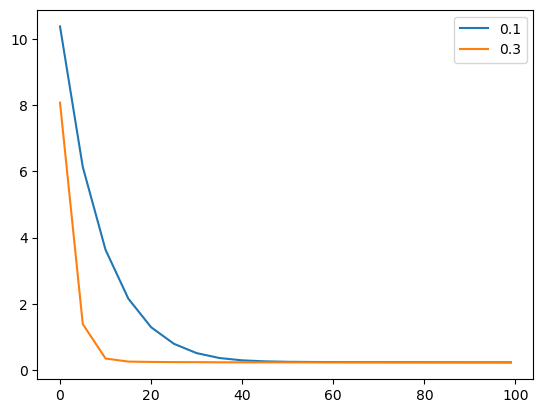

In [35]:
# Plot the scores to define the best 'eta'
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc,
        label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc,
        label='0.3')
plt.legend()
plt.show()

- Which **`eta`** leads to the **best RMSE** score on the validation dataset? = **Both give equal value**